## Mission Planning  - Shortest Path in a Road Network


Finds a shortest path in a road network graph.

This shortest path algorithm combines Dijkstra's and A* algorithms into one function. The type is selectable and Dijkstras is treated as a special case of A* where the heuristic function returns zero instead of the euclidean.

The heuristic function can easily be modified to accomplish distance related variants.

An example shows a detour attempt to bypass the shortest path.


The map graph is created from Open Street Map (OSM) data using the [OSMNX library](https://osmnx.readthedocs.io/en/stable/) and is represented to the algorithm
as a graph generated with the [NetworkX library](https://networkx.github.io/documentation/stable/). 




In [1]:
import osmnx as ox
import networkx as nx
import queue
import math
import priority_dict

In [3]:
# load berkeley map
berkely_map_graph = ox.graph_from_place('Berkeley, California', network_type='drive')

map_graph = berkely_map_graph #use this one

origin_node = ox.get_nearest_node(map_graph, (37.8743, -122.277)) # latitude and longitude 
goal_node = list(map_graph.nodes())[-1] #last node


Map using builtin shortest path routine from graphnx library



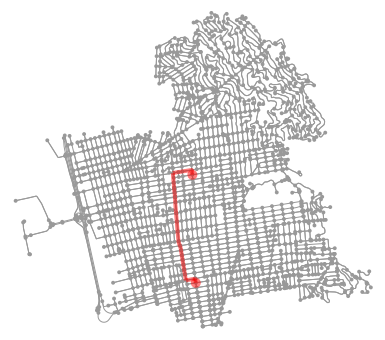

In [4]:
print()
print("Map using builtin shortest path routine from graphnx library")
print()
nx_shortest_path = nx.shortest_path(map_graph, origin_node, goal_node, weight='length')
fig, ax = ox.plot_graph_route(map_graph, nx_shortest_path)


In [5]:
# generates a path representation from the origin as a list of vertex keys
# by following the predecessor backpointers

def get_path(origin_key, goal_key, predecessors):
    key = goal_key
    path = [goal_key]
    
    while (key != origin_key):
        key = predecessors[key]
        path.insert(0, key)
        
    return path


In [6]:
# 
# adjustable heuristic, dijkstras or A* or 
# whatever the code is modified to respond to
#

def distance_heuristic(state_key, goal_key, node_data, htype=None):


# approximate the earthbound Euclidean distance between two vertices
# using osm graph node data
# assumes the earth is a sphere with radius 6371 km

    # which type
    if (htype == 'dijkstra' or htype is None):

        return 0.0
    
    elif (htype == 'astar'):
             
        n1 = node_data[state_key]
        n2 = node_data[goal_key]
    
        # get the longitude and latitude for vertices n1 & n2
        long1 = n1['x']*math.pi/180.0
        lat1 = n1['y']*math.pi/180.0
        
        long2 = n2['x']*math.pi/180.0
        lat2 = n2['y']*math.pi/180.0
        
        # spherical approximation of the earth for
        
        r = 6371000
        
        # estimate the distance between two points
        x1 = r*math.cos(lat1)*math.cos(long1)
        y1 = r*math.cos(lat1)*math.sin(long1)
        z1 = r*math.sin(lat1)
    
        x2 = r*math.cos(lat2)*math.cos(long2)
        y2 = r*math.cos(lat2)*math.sin(long2)
        z2 = r*math.sin(lat2)
    
        d = ((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)**0.5
        
        return d  #-25000
    
    else:

        return 0.0 # catch all 
    

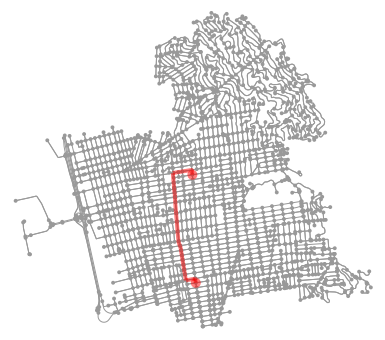

In [7]:
# compare to the builtin shortest path with 
nx_shortest_path = nx.shortest_path(map_graph, origin_node, goal_node, weight='length')
fig, ax = ox.plot_graph_route(map_graph, nx_shortest_path) 


In [10]:
def find_path(origin_node, goal_node, graph, algo_type=None):    
    
    # multipurpose 
    # select which algo type the heuristic is based on 
    
    # init:
    open_nodes = priority_dict.priority_dict({}) # nodes to process min-queue
    closed_nodes = {} # already processed nodes
    predecessors = {} # preceding nodes 
    costs = {} #A* u distance cost

    node_data = graph.nodes(True) #A* load spatial data for each vertex into 
    
    # dijkstras no cost so open_nodes[origin_node] = 0.0 #init origin node in open queue      
    open_nodes[origin_node] = distance_heuristic(origin_node, goal_node, node_data, algo_type)
    costs[origin_node] = 0.0 #A*
    #
    goal_found = False
    
    while (open_nodes): 

        u,u_dist=open_nodes.pop_smallest()
        u_dist=costs[u] #A* update w/ cost
        
        if u == goal_node:
            goal_found=True
            break
        
        for edge in graph.out_edges([u], data=True):
            v = edge[1]
            #print(v)
            if v in closed_nodes:
                continue
            # otherwise
            u2v_dist = edge[2]['length']
            
            if v in open_nodes:
                if u_dist + u2v_dist < costs[v]: #A*
                    open_nodes[v] = u_dist + u2v_dist + \
                        distance_heuristic(v, goal_node, node_data,algo_type) #A*
                    costs[v]=u_dist + u2v_dist #A*
                    predecessors[v]=u #A*
            else:
                open_nodes[v] = u_dist + u2v_dist  + \
                        distance_heuristic(v, goal_node, node_data,algo_type) #A*
                predecessors[v]=u
                costs[v]=u_dist + u2v_dist #A*
                
        # all of u adjecent nodes have been processed so 
        # put it in closed nodes not to revisit
        closed_nodes[u] = 1  
        
    # path never found
    if not goal_found:
        raise ValueError("Goal not found in search.")
    
    # construct a path from the predecessor nodes
    return get_path(origin_node, goal_node, predecessors)                



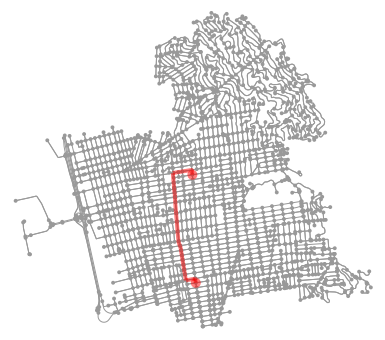

In [11]:
# default
path = find_path(origin_node, goal_node, map_graph)        
fig, ax = ox.plot_graph_route(map_graph, path) 


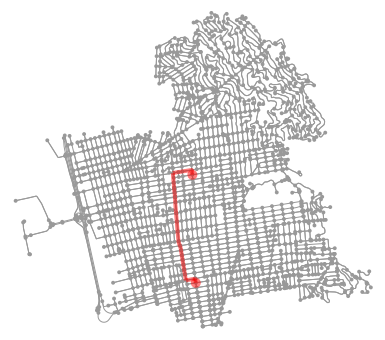

In [12]:
#dijkstras
path = find_path(origin_node, goal_node, map_graph, algo_type='dijkstra')        
fig, ax = ox.plot_graph_route(map_graph, path) 


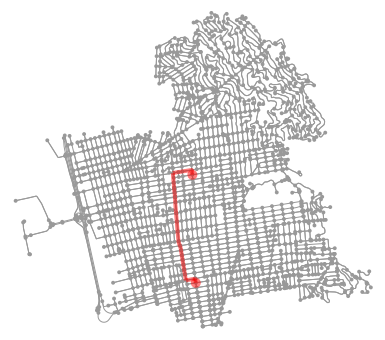

In [13]:
#A*
path = find_path(origin_node, goal_node, map_graph, algo_type='astar')        
fig, ax = ox.plot_graph_route(map_graph, path) 



### Test variations of return values for the distance heuristic

Modify the heuristic to attempt a detour of sorts

In [18]:
# modified for possible detour?

# adjustable heuristic, dijkstras or A* or 
# whatever the code is modified to respond to
#

def distance_heuristic(state_key, goal_key, node_data, htype=None):

# approximate the earthbound Euclidean distance between two vertices
# using osm graph node data
# assumes the earth is a sphere with radius 6371 km

    # which type
    if (htype == 'dijkstra' or htype is None):

        return 0.0
    
    elif (htype == 'astar'):
             
        n1 = node_data[state_key]
        n2 = node_data[goal_key]
    
        # get the longitude and latitude for vertices n1 & n2
        long1 = n1['x']*math.pi/180.0
        lat1 = n1['y']*math.pi/180.0
        
        long2 = n2['x']*math.pi/180.0
        lat2 = n2['y']*math.pi/180.0
        
        # spherical approximation of the earth for
        
        r = 6371000
        
        # estimate the distance between two points
        x1 = r*math.cos(lat1)*math.cos(long1)
        y1 = r*math.cos(lat1)*math.sin(long1)
        z1 = r*math.sin(lat1)
    
        x2 = r*math.cos(lat2)*math.cos(long2)
        y2 = r*math.cos(lat2)*math.sin(long2)
        z2 = r*math.sin(lat2)
    
        d = ((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)**0.5
        
        return d*50
    
    else:

        return 0.0 # catch all 
    

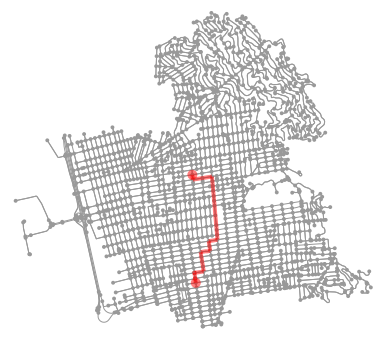

In [19]:
#A* detoured
path = find_path(origin_node, goal_node, map_graph, algo_type='astar')        
fig, ax = ox.plot_graph_route(map_graph, path) 

### Algorithm Pseudocode

#### Dijkstra's Algorithm


![Dijkstra's Pseudocode](dijkstra.png)



#### A* Algorithm
![A* Pseudocode](a_star.png)
